In [1]:
from itertools import chain
import json

import numpy as np
from numpy.polynomial.legendre import Legendre
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import ExpressionModel

In [2]:
df = pd.read_excel("Data/Simulated Ne beta parameters, TDCASSCF, 2018-12-18.xlsx", sheet_name="w2w")
df.head()

,target dataset,photon (eV),phi (deg),phi (rad),beta1,beta2,beta3,beta4,beta1m3
0,good1,15.9,0,0.000000,0.041486,-0.325020,0.412740,1.689466,-0.577623
1,good1,15.9,45,0.785398,0.298997,-0.324662,0.617323,1.689486,-0.626988
2,good1,15.9,90,1.570796,0.381801,-0.324688,0.460716,1.689356,-0.309273
3,good1,15.9,135,2.356194,0.241417,-0.325085,0.034634,1.689152,0.189466
4,good1,15.9,180,3.141593,-0.039976,-0.325619,-0.411426,1.688995,0.577163


In [3]:
def _expand(ser: pd.Series):
    f = Legendre([1, ser["beta1"], ser["beta2"], ser["beta3"], ser["beta4"]])
    x = np.arange(0, 180 + 1, 1)
    fx = f(np.cos(x / 180 * np.pi))
    return [
        {
            "Target dataset": ser["target dataset"],
            "Photon energy (eV)": ser["photon (eV)"],
            "Opt phase (deg)": ser["phi (deg)"],
            "Opt phase (mach unit)": ser["phi (deg)"] / 360,
            "Polar ang (deg)": ph,
            "Yield": y,
        }
        for ph, y in zip(x, fx)
    ]


def _fit(df: pd.DataFrame) -> pd.Series:
    model = ExpressionModel('amp * cos(freq * x - shift) + offset')
    model.set_param_hint('amp', value=df["Yield"].std(), min=0)
    model.set_param_hint('freq', value=np.pi/180, vary=False)
    at = df["Yield"].idxmax()
    ph = df["Opt phase (deg)"] * np.pi / 180 % (2 * np.pi)
    model.set_param_hint('shift', value=ph[at], min=-2*np.pi, max=2*np.pi)
    model.set_param_hint('offset', value=df["Yield"].mean())
    result = model.fit(df["Yield"], x=df["Opt phase (deg)"])
    return pd.Series({
        "Model result": result,
        "Photon energy (eV)": df["Photon energy (eV)"].iloc[0],
        "Polar ang (deg)": df["Polar ang (deg)"].iloc[0],
    })


it = chain.from_iterable(df.apply(_expand, axis=1))
expanded = pd.DataFrame([d for d in it])
fit = (
    expanded
    .groupby(["Target dataset", "Polar ang (deg)"])
    .apply(_fit)
)
fit.head()

Model result  \
Target dataset Polar ang (deg)                                                      
good1          0                <lmfit.model.ModelResult object at 0x7fc653380...   
               1                <lmfit.model.ModelResult object at 0x7fc65335c...   
               2                <lmfit.model.ModelResult object at 0x7fc653380...   
               3                <lmfit.model.ModelResult object at 0x7fc6532ed...   
               4                <lmfit.model.ModelResult object at 0x7fc6532ed...   

                                Photon energy (eV)  Polar ang (deg)  
Target dataset Polar ang (deg)                                       
good1          0                              15.9                0  
               1                              15.9                1  
               2                              15.9                2  
               3                              15.9                3  
               4                              15.9                4

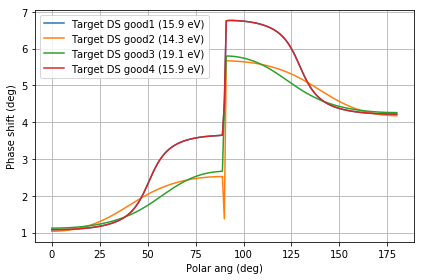

In [4]:
def _params(ser: pd.Series) -> pd.Series:
    offset = 1
    return pd.Series({
        "Phase shift (rad)": (ser["Model result"].params["shift"].value - offset) % (2 * np.pi) + offset,
        "Photon energy (eV)": ser["Photon energy (eV)"],
        "Polar ang (deg)": ser["Polar ang (deg)"],
    }) 


data = fit.apply(_params, axis=1)


colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
]

plt.figure()
plt.xlabel("Polar ang (deg)")
plt.ylabel("Phase shift (deg)")
for k, c in zip(["good1", "good2", "good3", "good4"], colors):
    sliced = data.loc[k, :]
    plt.plot(
        sliced.index,
        sliced["Phase shift (rad)"],
        color=c,
        label="Target DS {} ({} eV)".format(k, sliced["Photon energy (eV)"].iloc[0]),
    )
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

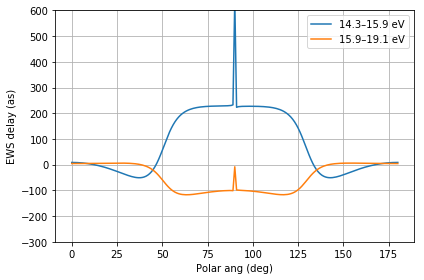

In [5]:
def _average(df: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "Phase shift (rad)": df["Phase shift (rad)"].mean(),
        "Photon energy (eV)": df["Photon energy (eV)"].iloc[0],
        "Polar ang (deg)": df["Polar ang (deg)"].iloc[0],
    })


def _sloop(df: pd.DataFrame) -> pd.DataFrame:
    x = df["Photon energy (eV)"].values
    index = pd.Index(x[:-1], name="Photon energy fr (eV)")
    dx = 2 * np.diff(x)
    dy = np.diff(df["Phase shift (rad)"])
    k = 24.1888432651 / 0.0367493
    return pd.DataFrame({
        "EWS delay (as)": dy / dx * k,
        "Photon energy fr (eV)": x[:-1],
        "Photon energy to (eV)": x[1:],
        "Polar ang (deg)": df["Polar ang (deg)"].iloc[0],
    }, index=index)


diff = (
    data
    .reset_index(level=1, drop=True)
    .groupby(["Photon energy (eV)", "Polar ang (deg)"])
    .apply(_average)
    .sort_index()  # Sort by photon energies
    .reset_index(drop=True)
    .groupby("Polar ang (deg)")
    .apply(_sloop)
)

plt.figure()
plt.xlabel("Polar ang (deg)")
plt.ylabel("EWS delay (as)")
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
]

for k, c in zip([14.3, 15.9], colors):
    sliced = diff.loc[pd.IndexSlice[:, k], :].reset_index(level=1, drop=True)
    plt.plot(
        sliced.index,
        sliced["EWS delay (as)"],
        label="{}–{} eV".format(sliced["Photon energy fr (eV)"].iloc[0],
                                sliced["Photon energy to (eV)"].iloc[0]),
    )
plt.ylim(-300, 600)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
with open("Data/Phase shifts - TDCASSCF.json", "w") as fp:
    json.dump(
        data
        .drop(columns="Polar ang (deg)")
        .reset_index()
        .to_dict("records"),
        fp,
        indent=2,
        sort_keys=True,
    )

with open("Data/EWS delays - TDCASSCF.json", "w") as fp:
    json.dump(
        diff.to_dict("records"),
        fp,
        indent=2,
        sort_keys=True,
    )